# Imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Configure hardware acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Algorithm Hardware Target: {device}")

Algorithm Hardware Target: cuda


# Data Loading and Transformation Pipeline

In [2]:
# 1. Define Transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Dataset from Kaggle Directory
data_dir = '/kaggle/input/plantvillage-dataset/color'
full_dataset = datasets.ImageFolder(data_dir)

# 3. Stratified Dataset Partitioning (80/10/10)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transforms
train_data.dataset.transform = train_transform
val_data.dataset.transform = val_test_transform
test_data.dataset.transform = val_test_transform

# 4. Initialize DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print(f"Data Partitions Verified:\n Training: {len(train_data)}\n Validation: {len(val_data)}\n Testing: {len(test_data)}")

Data Partitions Verified:
 Training: 43444
 Validation: 5430
 Testing: 5431


# Custom Transformer Architecture

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class PlantTransformer(nn.Module):
    def __init__(self, num_classes=38):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 768))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, 768))
        
        # 6 Encoder Blocks for Depth
        self.blocks = nn.ModuleList([TransformerBlock(768) for _ in range(6)])
        self.norm = nn.LayerNorm(768)
        self.head = nn.Linear(768, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        return self.head(self.norm(x[:, 0]))

model = PlantTransformer(num_classes=38).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Training, Logging, and Metric Algorithms

In [4]:
history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

epochs = 25
for epoch in range(epochs):
    start_time = time.time()
    
    # Training Phase
    model.train()
    t_loss, t_corr = 0.0, 0
    t_preds, t_labels = [], []
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, lbls)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * imgs.size(0)
        _, p = torch.max(outs, 1)
        t_corr += torch.sum(p == lbls.data)
        t_preds.extend(p.cpu().numpy()); t_labels.extend(lbls.cpu().numpy())

    # Validation Phase
    model.eval()
    v_loss, v_corr = 0.0, 0
    v_preds, v_labels = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            loss = criterion(outs, lbls)
            v_loss += loss.item() * imgs.size(0)
            _, p = torch.max(outs, 1)
            v_corr += torch.sum(p == lbls.data)
            v_preds.extend(p.cpu().numpy()); v_labels.extend(lbls.cpu().numpy())

    # Record Epoch Metrics
    history['train_loss'].append(t_loss/len(train_data))
    history['train_acc'].append((t_corr/len(train_data)).item())
    history['train_f1'].append(f1_score(t_labels, t_preds, average='macro'))
    history['val_loss'].append(v_loss/len(val_data))
    history['val_acc'].append((v_corr/len(val_data)).item())
    history['val_f1'].append(f1_score(v_labels, v_preds, average='macro'))

    print(f"Epoch {epoch+1}/{epochs} ({time.time()-start_time:.1f}s) | "
          f"Val Acc: {history['val_acc'][-1]:.3f} | Val F1: {history['val_f1'][-1]:.3f}")

Epoch 1/25 (552.9s) | Val Acc: 0.741 | Val F1: 0.646
Epoch 2/25 (552.6s) | Val Acc: 0.733 | Val F1: 0.647
Epoch 3/25 (554.3s) | Val Acc: 0.773 | Val F1: 0.695
Epoch 4/25 (554.3s) | Val Acc: 0.776 | Val F1: 0.701
Epoch 5/25 (555.2s) | Val Acc: 0.715 | Val F1: 0.628
Epoch 6/25 (554.8s) | Val Acc: 0.698 | Val F1: 0.600
Epoch 7/25 (555.0s) | Val Acc: 0.713 | Val F1: 0.634
Epoch 8/25 (554.6s) | Val Acc: 0.772 | Val F1: 0.700
Epoch 9/25 (554.9s) | Val Acc: 0.593 | Val F1: 0.513
Epoch 10/25 (555.4s) | Val Acc: 0.754 | Val F1: 0.666
Epoch 11/25 (554.7s) | Val Acc: 0.745 | Val F1: 0.676
Epoch 12/25 (555.0s) | Val Acc: 0.664 | Val F1: 0.558
Epoch 13/25 (555.3s) | Val Acc: 0.763 | Val F1: 0.684
Epoch 14/25 (554.4s) | Val Acc: 0.751 | Val F1: 0.669
Epoch 15/25 (553.6s) | Val Acc: 0.653 | Val F1: 0.544
Epoch 16/25 (553.9s) | Val Acc: 0.577 | Val F1: 0.453
Epoch 17/25 (553.6s) | Val Acc: 0.650 | Val F1: 0.541
Epoch 18/25 (553.6s) | Val Acc: 0.716 | Val F1: 0.636
Epoch 19/25 (554.1s) | Val Acc: 0.710

# Visualization and Test Evaluation

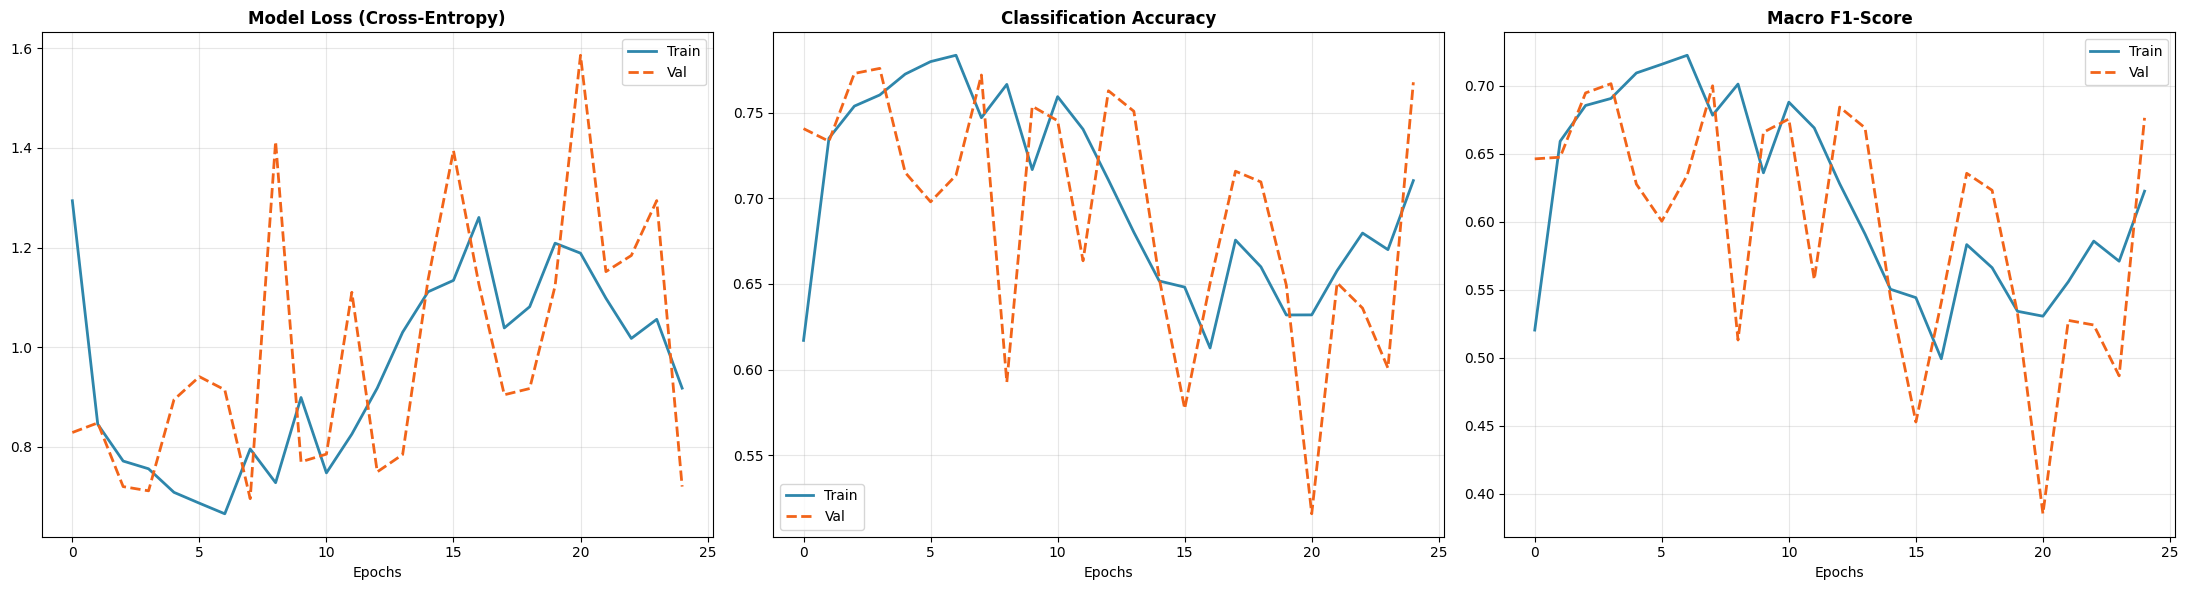


--- Final Performance Summary ---
Final Test Accuracy: 0.7720
Final Test F1 (Macro): 0.6894


In [5]:
# 1. Visualization Suite
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
metrics = ['loss', 'acc', 'f1']
titles = ['Model Loss (Cross-Entropy)', 'Classification Accuracy', 'Macro F1-Score']

for i, m in enumerate(metrics):
    axes[i].plot(history[f'train_{m}'], label='Train', color='#2E86AB', lw=2)
    axes[i].plot(history[f'val_{m}'], label='Val', color='#F26419', lw=2, linestyle='--')
    axes[i].set_title(titles[i], fontweight='bold')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Final Test Performance
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = model(imgs)
        _, p = torch.max(outs, 1)
        test_preds.extend(p.cpu().numpy()); test_labels.extend(lbls.cpu().numpy())

print("\n--- Final Performance Summary ---")
print(f"Final Test Accuracy: {np.mean(np.array(test_preds) == np.array(test_labels)):.4f}")
print(f"Final Test F1 (Macro): {f1_score(test_labels, test_preds, average='macro'):.4f}")